# Background info

## National Primary Drinking Water Regulations (NPDWR)

<strong>National Primary Drinking Water Regulations (NPDWR)</strong> are legally enforceable primary standards and treatment techniques that apply to public water systems. Primary standards and treatment techniques protect public health by limiting the levels of contaminants in drinking water.


|Microorganisms|
|Disinfectants|
|Disinfection Byproducts|
|Inorganic Chemicals|
|Organic Chemicals|
|Radionuclides|

https://www.epa.gov/ground-water-and-drinking-water/national-primary-drinking-water-regulations

## National Secondary Drinking Water Regulations (NSDWRs)

<strong>National Secondary Drinking Water Regulations (NSDWRs)</strong> or secondary standards are non-enforceable guidelines regulating contaminants that may cause cosmetic effects (such as skin or tooth discoloration) or aesthetic effects (such as taste, odor, or color) in drinking water. EPA recommends secondary standards to water systems but does not require systems to comply with the standard. However, states may choose to adopt them as enforceable standards.

While secondary standards are not federally enforceable, EPA requires a special notice for exceedance of the fluoride secondary standard of 2.0 mg/L. Community water systems that exceed the fluoride secondary standard of 2 mg/L, but do not exceed the primary standard of 4.0 mg/L for fluoride, must provide public notice to persons served no later than 12 months from the day the water system learns of the exceedance (40 CFR 141.208).

List of National Secondary Drinking Water Regulations:

|Contaminant	| Secondary Standard |
| ------------- |:-------------:|
|Aluminum|	0.05 to 0.2 mg/L
|Chloride|	250 mg/L
|Color|	15 (color units)
|Copper|	1.0 mg/L
|Corrosivity|	noncorrosive
|Fluoride|	2.0 mg/L
|Foaming Agents|	0.5 mg/L
|Iron|	0.3 mg/L
|Manganese|	0.05 mg/L
|Odor|	3 threshold odor number
|pH|	6.5-8.5
|Silver|	0.10 mg/L
|Sulfate|	250 mg/L
|Total Dissolved Solids|	500 mg/L
|Zinc|	5 mg/L

https://www.epa.gov/dwregdev/drinking-water-regulations-and-contaminants

# Analysis

## Import the packages

In [2]:
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pprint import pprint
import openweathermapy.core as owm
import seaborn as sns
import numpy as np

## Data Source

California Natural Resources Agency: Period of Record by Station and Parameter https://data.cnra.ca.gov/dataset/water-quality-data/resource/8ff3a841-d843-405a-a360-30c740cc8691

We'll be working from a CSV document, downloaded from the url cited above. An API is also available.

## Filter the dataset

#### Filtering the Raw Dataset

In [5]:
# Import the data (would have rather used the API, but the csv will do for now)
data = "data/lab-results.csv"
df = pd.read_csv(data)

print(df.shape) # yikes! --> (4278088, 17)

# We need to filter this huge dataset, perhaps by selecting sample measurements from 2000 onward.

(4278088, 17)


In [6]:
# I want to categorize my data by years; I need to splice the data field
df["sampleYear"] = pd.DatetimeIndex(df['SAMPLE_DATE']).year

Filtering the Raw Dataset between the years 2000-present (2018)

In [7]:
df = df[(df['sampleYear'] > 1999) & (df['sampleYear'] <= 2018)]
print(df.shape) # OK...somewhat better --> (874334, 18)
print(df.columns) 

(874334, 18)
Index(['STATION_ID', 'STATION_NAME', 'FULL_STATION_NAME', 'STATION_NUMBER',
       'STATION_TYPE', 'LATITUDE', 'LONGITUDE', 'COUNTY_NAME', 'SAMPLE_CODE',
       'SAMPLE_DATE', 'SAMPLE_DEPTH', 'SAMPLE_DEPTH_UNITS', 'PARAMETER',
       'RESULT', 'REPORTING_LIMIT', 'UNITS', 'METHOD_NAME', 'sampleYear'],
      dtype='object')


In [12]:
print('-------------------Filter Data Summary---------------------')
print('')
print('--------------------Sample Size per Year, 2000-2018---------------------')
print(df.groupby('sampleYear').size())
print('')
print('----------------Count of Parameters measurements--------------------')
print(pd.value_counts(df['PARAMETER'].values, sort=True))

-------------------Filter Data Summary---------------------

--------------------Sample Size per Year, 2000-2018---------------------
sampleYear
2000    52323
2001    61553
2002    44572
2003    71396
2004    69077
2005    59710
2006    66716
2007    61033
2008    41868
2009    41151
2010    39286
2011    43660
2012    41479
2013    31578
2014    34889
2015    36559
2016    36421
2017    32893
2018     8170
dtype: int64

----------------Count of Parameters measurements--------------------
Dissolved Chloride               20759
Total Dissolved Solids           19274
Dissolved Sulfate                18733
Dissolved Ammonia                18620
Dissolved Calcium                18352
Dissolved Magnesium              18209
Dissolved Sodium                 18095
Dissolved Boron                  18079
Dissolved Hardness               18009
Dissolved Ortho-phosphate        17704
Dissolved Nitrate + Nitrite      17582
pH                               17057
Total Alkalinity                 16667

In [13]:
df['PARAMETER'].unique()

array(['Dissolved Aluminum', 'Dissolved Ammonia', 'Dissolved Antimony',
       'Dissolved Arsenic', 'Dissolved Barium', 'Dissolved Beryllium',
       'Dissolved Boron', 'Dissolved Bromide', 'Dissolved Cadmium',
       'Dissolved Calcium', 'Dissolved Chloride', 'Dissolved Chromium',
       'Dissolved Copper', 'Dissolved Fluoride', 'Dissolved Hardness',
       'Dissolved Iron', 'Dissolved Lead', 'Dissolved Magnesium',
       'Dissolved Manganese', 'Dissolved Mercury', 'Dissolved Nickel',
       'Dissolved Nitrate', 'Dissolved Nitrate + Nitrite',
       'Dissolved Ortho-phosphate', 'Dissolved Selenium',
       'Dissolved Silver', 'Dissolved Sodium', 'Dissolved Sulfate',
       'Dissolved Zinc', 'Specific Conductance', 'Total Alkalinity',
       'Total Dissolved Solids', 'Total Kjeldahl Nitrogen',
       'Total Phosphorus', 'pH', '1,1,1,2-Tetrachloroethane',
       '1,1,1-Trichloroethane', '1,1,2,2-Tetrachloroethane',
       '1,1,2-Trichloroethane', '1,1-Dichloroethane',
       '1,1-Dichlo

Now we'll select the PARAMETER attributes, i.e. the contaminants of interest for our analysis, into separate dataframes: primary and secondary water standards as defined by the EPA. We'll furthermore re-export these dataframes into their respective CSVs due to GitHub's upload restriction (the raw CSV file exceeding well 100.00 MB; hence why you won't find the original CSV on this GitHub's data folder). 

In [17]:
PMCLs = df.loc[(df['PARAMETER'] == 'Total Arsenic') | (df['PARAMETER'] == 'Total Mercury') | (df['PARAMETER'] == 'Dissolved Nitrate') | (df['PARAMETER'] == 'Total Lead') | (df['PARAMETER'] == 'Total Selenium')]
print(PMCLs.shape) 
SMCLs = df.loc[(df['PARAMETER'] == 'Total Aluminum') | (df['PARAMETER'] == 'Dissolved Chloride') | (df['PARAMETER'] == 'Color') | (df['PARAMETER'] == 'Total Copper') | (df['PARAMETER'] == 'Dissolved Fluoride')  | (df['PARAMETER'] == 'Total Iron')  | (df['PARAMETER'] == 'Dissolved Manganese')  | (df['PARAMETER'] == 'pH')| (df['PARAMETER'] == 'Total Silver')| (df['PARAMETER'] == 'Dissolved Sulfate')| (df['PARAMETER'] == 'Total Dissolved Solids')| (df['PARAMETER'] == 'Total Zinc')]
print(SMCLs.shape) 

print("missing SMCLs: Corrosivity, Foaming Agents, Odor")

(34510, 18)
(126890, 18)
missing SMCLs: Corrosivity, Foaming Agents, Odor


Re-export to a csv

In [18]:
PMCLs.to_csv("data/PMCLs_00-18.csv",index=False)
SMCLs.to_csv("data/SMCLs_00-18.csv",index=False)

## Observe the distribution

### PMCLs

Re-import the csv to dataframe

In [20]:
PMCLs = pd.read_csv("data/PMCLs_00-18.csv")
PMCLs = PMCLs.drop(['STATION_NAME','STATION_NUMBER'],
                        axis=1)

### Geographic distribution of samples

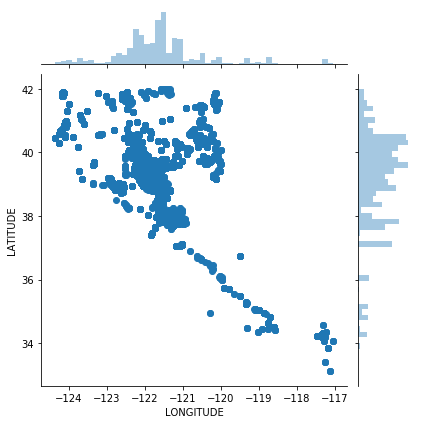

In [22]:
X = PMCLs[['LATITUDE', 'LONGITUDE']].values
sns.jointplot(x="LONGITUDE", y="LATITUDE", data=PMCLs);

In [33]:
print('-------------------Filter Data Summary---------------------')
print('')
print('--------------------Sample Size per Year, 2000-2018---------------------')
print(PMCLs.groupby('sampleYear').size())
print('')
print('----------------Count of Parameter measurements--------------------')
print(pd.value_counts(PMCLs['PARAMETER'].values, sort=True))

-------------------Filter Data Summary---------------------

--------------------Sample Size per Year, 2000-2018---------------------
sampleYear
2000     522
2001     823
2002     605
2003    2475
2004    3026
2005    2782
2006    2993
2007    2668
2008    1638
2009    1346
2010    1386
2011    1887
2012    2229
2013    1839
2014    1936
2015    2131
2016    2029
2017    1821
2018     374
dtype: int64

----------------Count of Parameter measurements--------------------
Dissolved Nitrate    10264
Total Arsenic         7747
Total Lead            7423
Total Selenium        7237
Total Mercury         1839
dtype: int64


### Histogram

#### Normalize the units for all measurements

Convert all where the unit measurement is ug/L to mg/L (1000 mg/L = 1 ug/L); (1000000 mg/L = 1 ng/L)

In [55]:
print("Unit types: " + str(PMCLs['UNITS'].unique()))

# Conversion query ug/L -> mg/L
PMCLs['RESULT'] = np.where(PMCLs['UNITS'] == 'ug/L', PMCLs['RESULT'] / 1000, PMCLs['RESULT'])

# Conversion query ng/L -> mg/L
PMCLs['RESULT'] = np.where(PMCLs['UNITS'] == 'ng/L', PMCLs['RESULT'] / 1000000, PMCLs['RESULT'])

Unit types: ['mg/L' 'ug/L' 'ng/L']


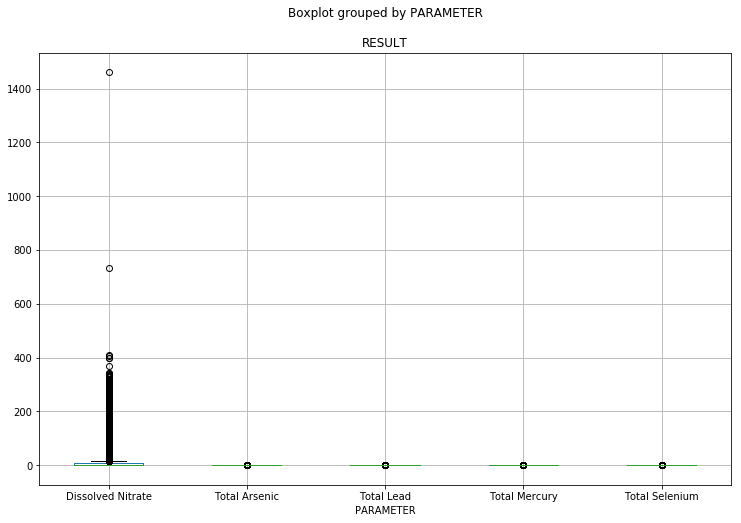

In [58]:
PMCLs.boxplot(column="RESULT",        # Column to plot
                 by= "PARAMETER",         # Column to split upon
                 figsize= (12,8))  

We may need to bin the histograms to avoid outliers skewing our observation; some outliers can also be the product of error during data entry!

Also a separate histogram between Dissolved Nitrate and the rest would be probably best!

### PMCLs

### Geographic distribution of samples

Re-import the csv to dataframe

In [28]:
SMCLs = pd.read_csv("data/SMCLs_00-18.csv")
SMCLs = SMCLs.drop(['STATION_NAME','STATION_NUMBER'],
                        axis=1)

### Geographic distribution of samples

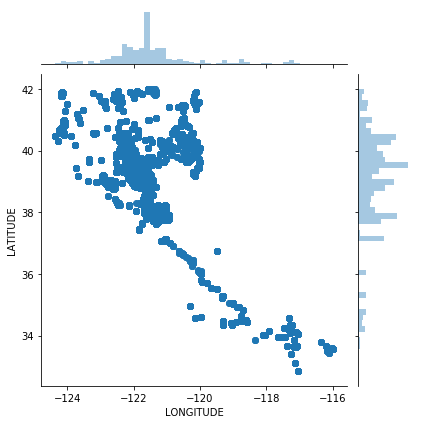

In [29]:
X = SMCLs[['LATITUDE', 'LONGITUDE']].values
sns.jointplot(x="LONGITUDE", y="LATITUDE", data=SMCLs);

In [34]:
print('-------------------Filter Data Summary---------------------')
print('')
print('--------------------Sample Size per Year, 2000-2018---------------------')
print(SMCLs.groupby('sampleYear').size())
print('')
print('----------------Count of Parameter measurements--------------------')
print(pd.value_counts(SMCLs['PARAMETER'].values, sort=True))

-------------------Filter Data Summary---------------------

--------------------Sample Size per Year, 2000-2018---------------------
sampleYear
2000     4926
2001     5261
2002     5519
2003    10299
2004    11142
2005    10354
2006     9808
2007     8605
2008     6225
2009     5534
2010     5616
2011     6318
2012     6718
2013     5277
2014     5946
2015     6135
2016     6304
2017     5677
2018     1226
dtype: int64

----------------Count of Parameter measurements--------------------
Dissolved Chloride        20759
Total Dissolved Solids    19274
Dissolved Sulfate         18733
pH                        17057
Dissolved Manganese       10308
Total Iron                 8393
Total Aluminum             7985
Total Copper               7850
Total Zinc                 7427
Total Silver               7168
Dissolved Fluoride         1918
Color                        18
dtype: int64


### Histogram

<strong> Warning! Certain contaminants were measured with different units (Total Aluminum measured in both mg/L & ug/L for example); make sure to normalize the data if need be!

#### Normalize the units for all measurements

Convert all where the unit measurement is ug/L to mg/L (1000 mg/L = 1 ug/L)

In [49]:
print("Unit types: " + str(SMCLs['UNITS'].unique()))

# Conversion query
SMCLs['RESULT'] = np.where(SMCLs['UNITS'] == 'ug/L', SMCLs['RESULT'] / 1000, SMCLs['RESULT'])

Unit types: ['mg/L' 'pH Units' 'ug/L' 'Color Units']


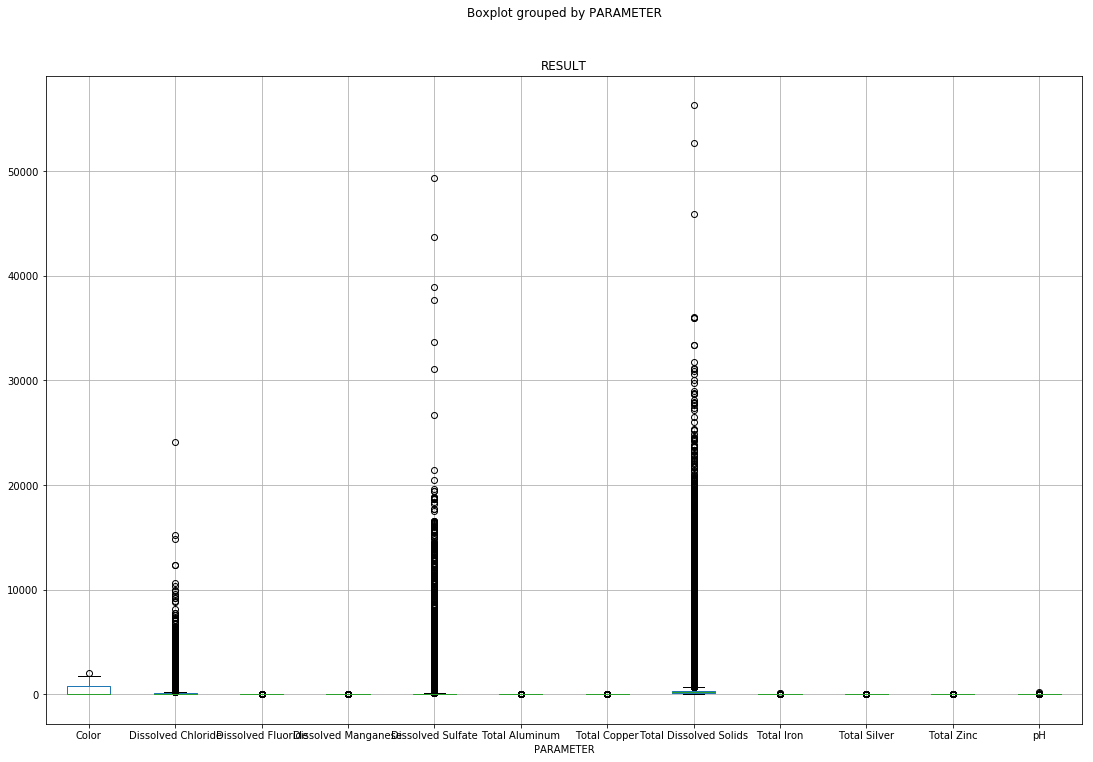

In [45]:
SMCLs.boxplot(column="RESULT",        # Column to plot
                 by= "PARAMETER",         # Column to split upon
                 figsize= (18,12))

We need to separate histogram by measurement units to get a better observational picture.